# Diversity Analysis
In this notebook we will explore some diversity aspect of the generated ligands. This includes
* Murcko scaffold analysis
* Tanimoto similarity

In [27]:
import math

import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from IPython.core.display import HTML
from rdkit.Chem import AllChem, Draw, PandasTools, rdFingerprintGenerator

from src.evaluation.utils import (draw_colored_scaffold_ligands,
                              max_tanimoto_similarity,
                              mean_tanimoto_similarity, read_mols,
                              tanimoto_similarity_matrix)

PandasTools.RenderImagesInAllDataFrames(images=True)

## Load and prepare ligands
Load generated ligands and remove ligands with a binding affinity > 1,000 nm

In [28]:
# read data
data = read_mols('../results_5n1f_25_02/5n1f/results.sdf')

,ROMol,binding_affinity,docking_score,num_fragments,inchi,AP,SE,FP,GA,B1,B2,AP_smiles,SE_smiles,FP_smiles,GA_smiles,B1_smiles,B2_smiles
0,,0.825466,133.57,2,"InChI=1S/C24H29N5/c1-23(2,3)19-6-4-17(5-7-19)1...",136,None,8,NaN,None,None,[4*]c1ccnc2[nH]cc(C#N)c12,None,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,None,None,None
1,,1.738471,67.60,2,InChI=1S/C23H25ClN4/c1-2-26-22-27-14-11-21(28-...,420,None,7,NaN,None,None,[16*]c1ccnc(N[C@H]([56*])C)n1,None,Clc1ccc(C2(c3ccccc3)CC[NH2+]CC2)cc1,None,None,None
2,,2.240375,29.01,2,InChI=1S/C23H20Cl2N4/c24-18-7-5-17(6-8-18)23(9...,8,None,7,NaN,None,None,[17*]c1ncnc2[nH]cc(Cl)c12,None,Clc1ccc(C2(c3ccccc3)CC[NH2+]CC2)cc1,None,None,None
3,,2.925760,124.80,2,InChI=1S/C18H19N5O2/c1-19-16-10-15-13(11-21-16...,327,None,348,NaN,None,None,[22*]n1c(=O)c([41*])cc2cnc(NC)cc21,None,CCC(=O)NCc1ccccn1,None,None,None
4,,3.619756,41.54,2,"InChI=1S/C21H29ClN4/c1-20(2,3)16-6-4-15(5-7-16...",220,None,8,NaN,None,None,[4*]Nc1cc([16*])c(Cl)cn1,None,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,None,None,None

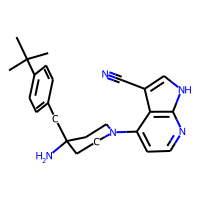
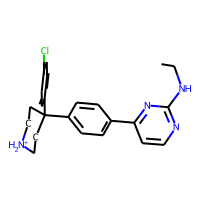
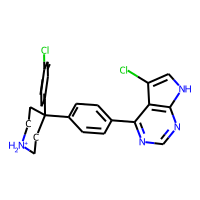
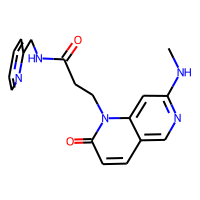
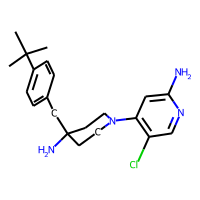

In [29]:
# remove ligands with unfavourable binding affnity
data = data[data['binding_affinity'] <= 1000].copy().reset_index(drop=True)
HTML(data.head().to_html(notebook=True))

In [30]:
print(f"Duplicates: {sum(data.inchi.duplicated())}")

Duplicates: 30


## Murcko Similarity
A Murcko scaffold can be used to represent the core structure of a ligand. It is the union of all rings and linkers - between rings -  of a molecule, thus disregarding the side chains. Here, we will use these Murcko scaffolds to analyse the diversity of the generated ligands from a structural point of view. First, we will look at the quantities of the scaffolds. Next, we determine the most frequent scaffolds. Lastly, we *measure* the information-based entropy of the scaffold using the Shannon-Entropy.

In [31]:
# add murcko smiles to dataframe
PandasTools.AddMurckoToFrame(data)

In [32]:
# determine distinct scaffold
scaffolds = data.groupby('Murcko_SMILES').size()
scaffolds = scaffolds.sort_values(ascending=False)

In [33]:
# assigned each distinct scaffold to an ID
data['scaffold_id'] = data.apply(lambda x: scaffolds.index.get_loc(x.Murcko_SMILES), axis=1)

Let's take a look at the quantities and frequencies of the scaffolds, and inspect the most frequent scaffolds.

In [34]:
print(f"Number of unique scaffolds: {scaffolds.size}")
print(f"Number of singletons: {sum(scaffolds == 1)}")

Number of unique scaffolds: 800
Number of singletons: 598


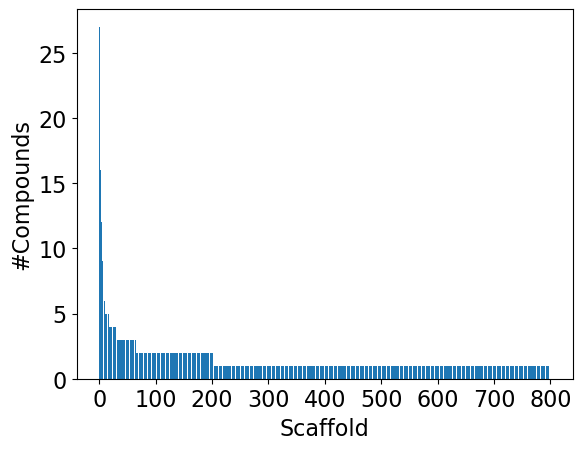

In [35]:
# plot top 15 scaffolds 
plt.bar(range(len(scaffolds)), scaffolds)
plt.ylabel('#Compounds', fontsize=16)
plt.xlabel('Scaffold', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [36]:
print(f"The most frequent scaffold is represented by {scaffolds[0]} compounds ({scaffolds[0]/data.index.size * 100}%)")

The most frequent scaffold is represented by 27 compounds (2.25752508361204%)


The 20 most frequent scaffold:

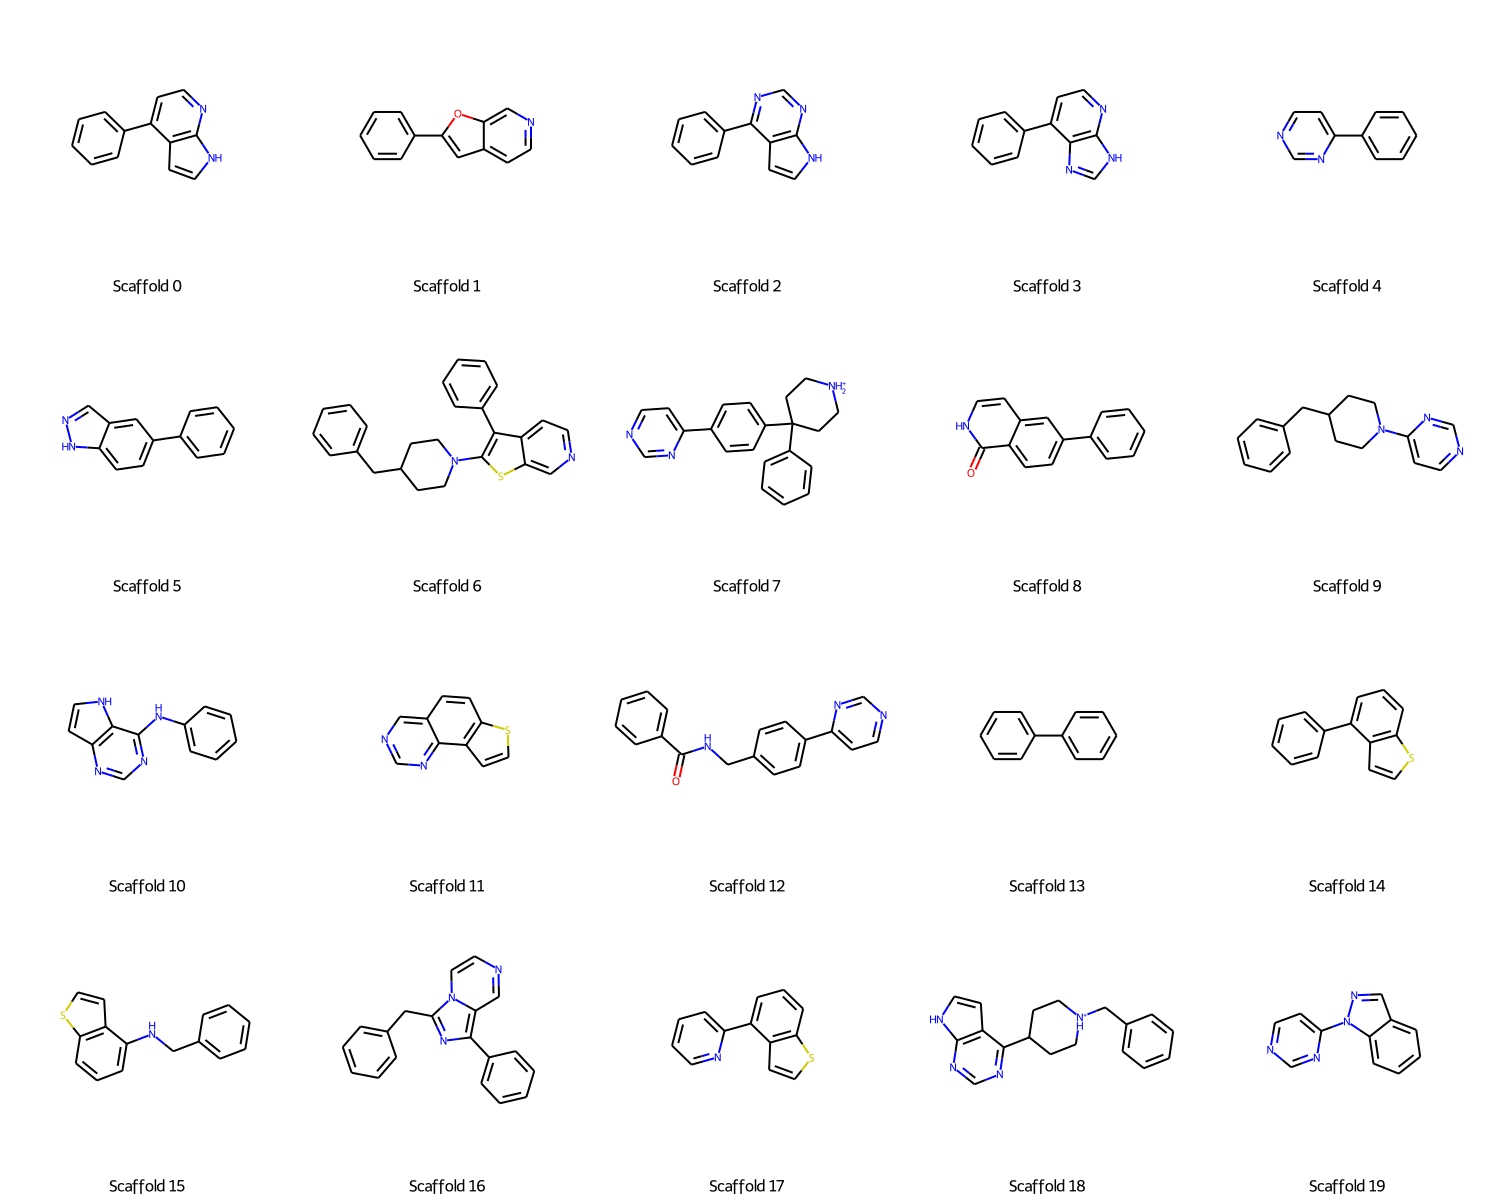

In [37]:
# print most common scaffolds
mols = [AllChem.MolFromSmiles(idx) for idx in scaffolds.index[:20]]
for mol in mols:
    AllChem.Compute2DCoords(mol)
img = Draw.MolsToGridImage(
    mols, 
    legends=[
        f"Scaffold {i}" for i in range(20)
    ],  
    molsPerRow=5, 
    maxMols=100,
    subImgSize=(300, 300)
)
img

Ligands that represent the 5 most frequent scaffold (5 ligands per scaffold) with colored scaffolds:

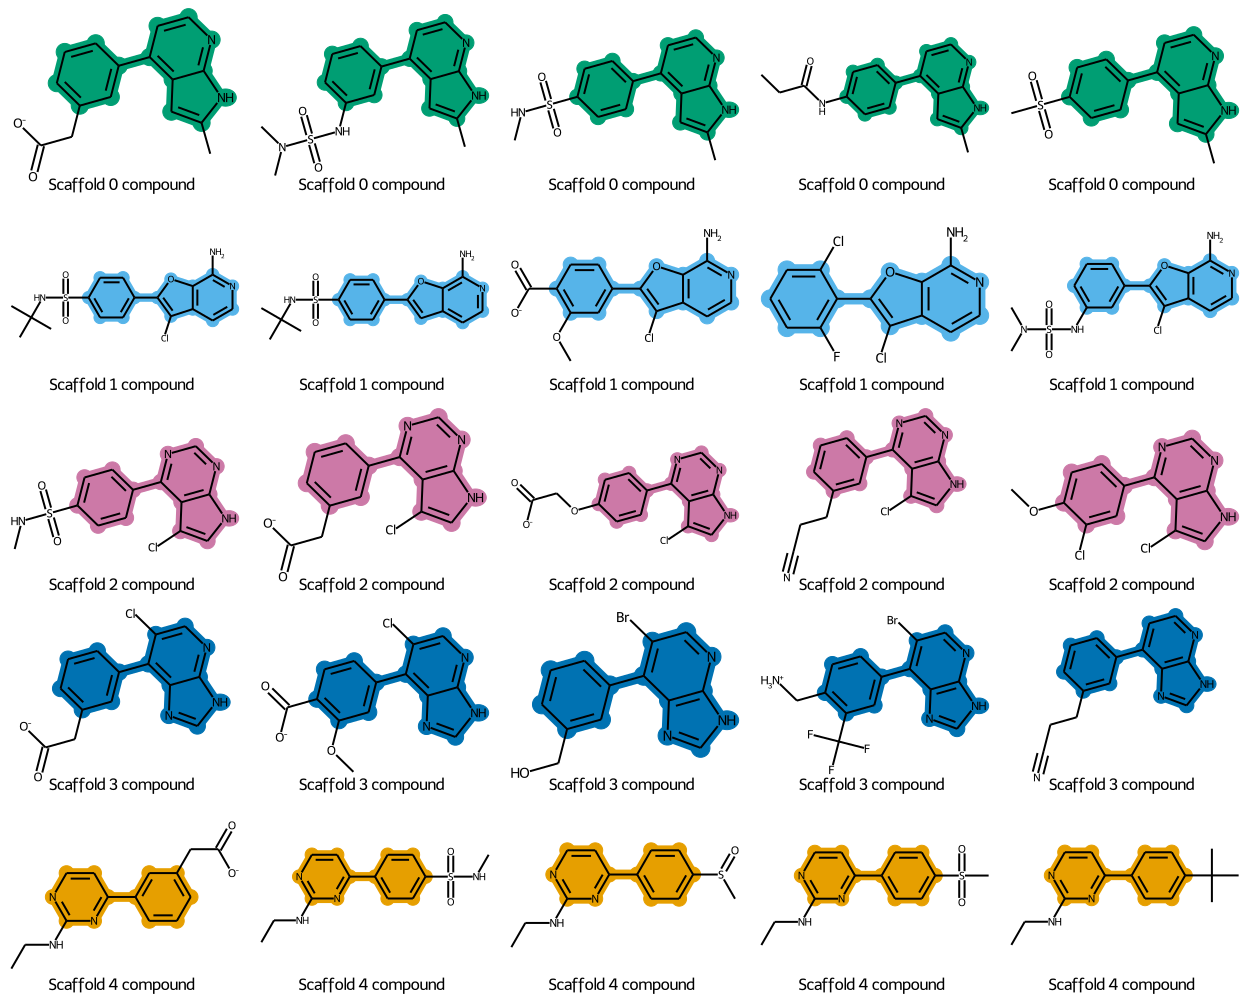

In [38]:
display.Image(draw_colored_scaffold_ligands(data))

In the following, we will look at the estimated binding affinity of the ligands with the most frequent scaffolds

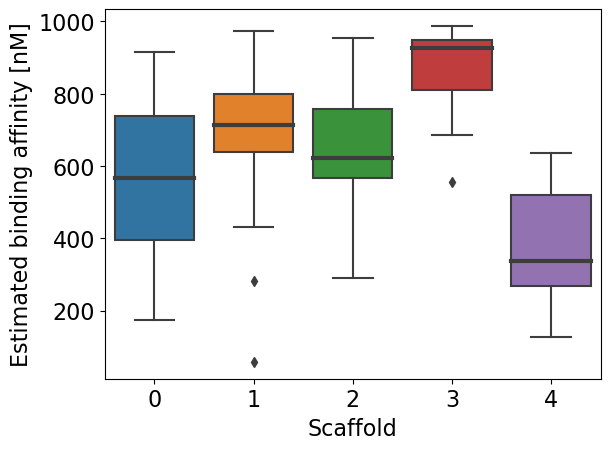

In [39]:
# plot binding affinity of top 5
sns.boxplot(
    x = 'scaffold_id',
    y='binding_affinity',
    data=data[data['scaffold_id'] < 5],
    medianprops={"linewidth": 3, "linestyle": "-"},
    )
plt.ylabel('Estimated binding affinity [nM]', fontsize=16)
plt.xlabel('Scaffold', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Now, we will inspect the frequency of distinct AP fragments per scaffold.

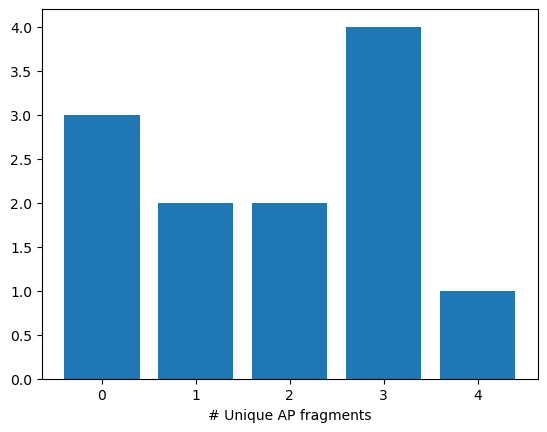

In [40]:
# unique AP fragments per scaffold
plt.bar(range(5), [data[data['scaffold_id'] == i]['AP'].unique().size for i in range(5)])
plt.xlabel("# Unique AP fragments")
plt.show()

Distinct AP fragments of the 5 most frequent scaffolds:

Legend: Fragment id | Scaffold


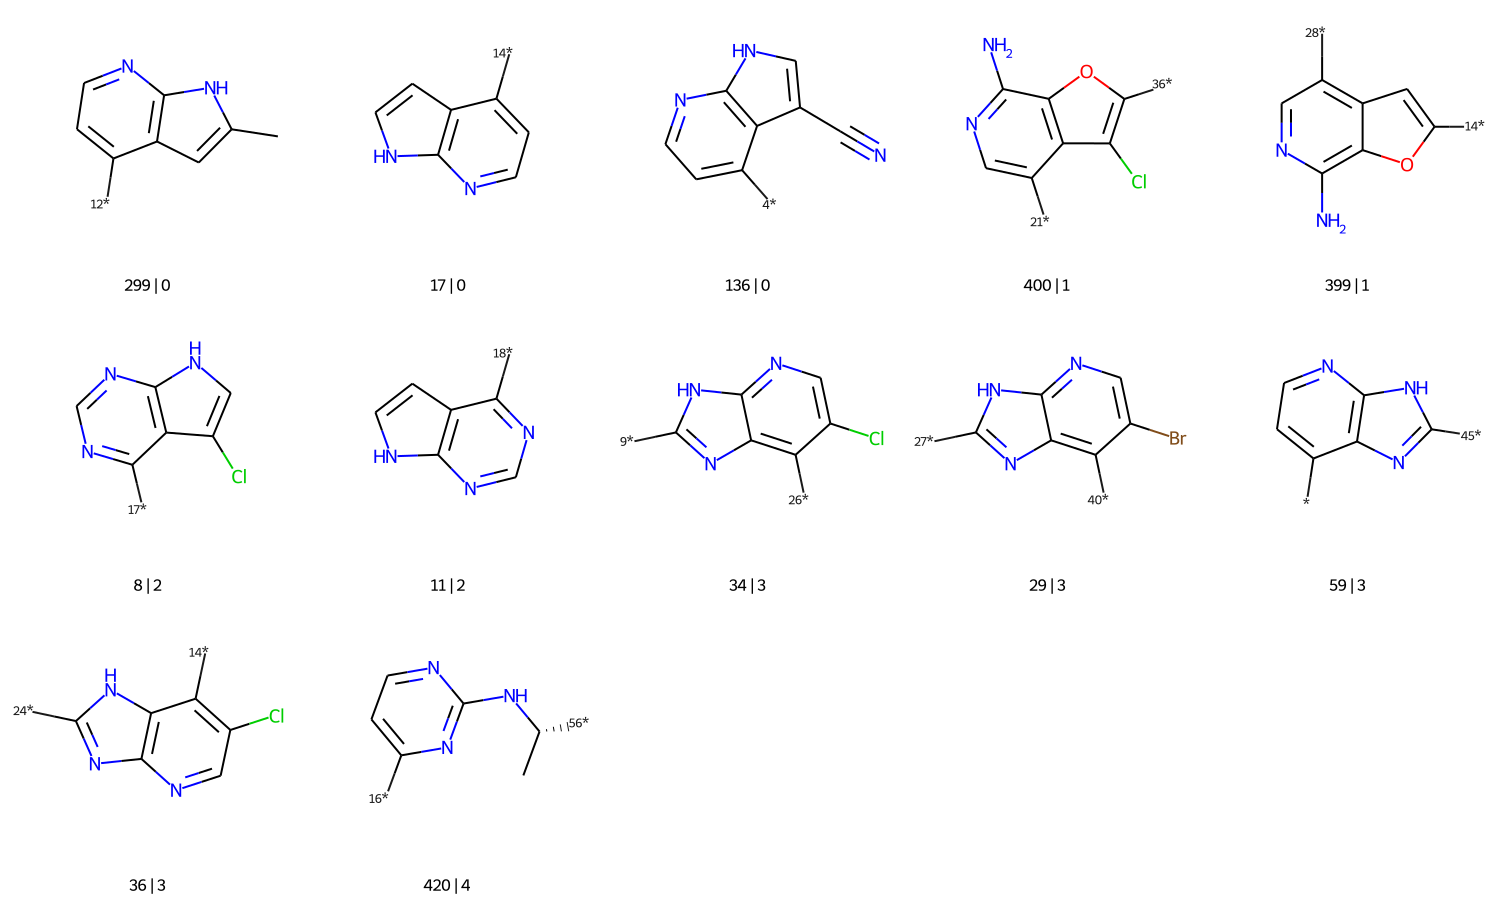

In [41]:
# get unique AP fragments of the 5 most frequent scaffolds
mols = []
legend = []
for i in range(5):
    scaffold_compounds = data[data['scaffold_id'] == i]
    mols += [AllChem.MolFromSmiles(mol) for mol in scaffold_compounds['AP_smiles'].unique()]
    legend += [f"{id} | {i}" for id in scaffold_compounds['AP'].unique()]

for mol in mols:
    AllChem.Compute2DCoords(mol)
    
print(f"Legend: Fragment id | Scaffold")
Draw.MolsToGridImage(
    mols, 
    legends=legend,  
    molsPerRow=5, 
    maxMols=100,
    subImgSize=(300, 300)
)

### Shannon entropy
To *measure* the entropy of the $n$ distinct scaffolds, we calculate the Shannon Entropy 

$SE = \sum_{i=1}^np_ilog_2(p_i)$,

where $p_i$ is the frequency of scaffold $i$ in the set of generated ligands. The scaled SE

$SSE = \frac{SE}{log_2(n)}$

scales the $SE$ to a value between $0$ and $1$. A SSE near $1$ indicates a high entropy, while a value equal $0$ means, that all compounds have the same scaffold.

In [42]:
# Shannon entropy
P = data.index.size
se = - sum((scaffold / P) * math.log2(scaffold / P) for scaffold in scaffolds)
sse = se / math.log2(scaffolds.size)
print(f"SE: {se}\nSSE: {sse}")

SE: 9.279174320060456
SSE: 0.9621850572490973


## Tanimoto similarity
To analyse the fingerprint-based diversity of the dataset, we determine the RDKit (topological) fingerprints of all compounds and calculate the Tanimoto coefficient of all pairs of compound fingerprints.

In [43]:
# generate and add rdkit fingerprint to dataframe
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
data['rdkit_fingerprint'] = [rdkit_gen.GetFingerprint(Chem.MolFromInchi(ligand_inchi)) for ligand_inchi in data.inchi]

In [44]:
data['mean_tanimoto_sims'] = data['rdkit_fingerprint'].apply(lambda fp: mean_tanimoto_similarity(data['rdkit_fingerprint'], fp))
data['nearest_neighbor_sim'] = data['rdkit_fingerprint'].apply(lambda fp: max_tanimoto_similarity(data['rdkit_fingerprint'], fp))

,ROMol,binding_affinity,docking_score,num_fragments,inchi,AP,SE,FP,GA,B1,B2,AP_smiles,SE_smiles,FP_smiles,GA_smiles,B1_smiles,B2_smiles,Murcko_SMILES,scaffold_id,rdkit_fingerprint,mean_tanimoto_sims,nearest_neighbor_sim
432,,324.514937,136.52,2,InChI=1S/C12H11ClN6/c1-19(2)9-3-7(4-17-18-9)10...,34,None,463,NaN,None,None,[9*]c1nc2c([26*])c(Cl)cnc2[nH]1,None,CN(C)c1cccnn1,None,None,None,c1cc(-c2ccnc3[nH]cnc23)cnn1,21,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",0.217971,1.0
384,,288.329087,142.43,2,InChI=1S/C12H11ClN6/c1-19(2)9-3-7(4-17-18-9)10...,36,None,463,NaN,None,None,[14*]c1c(Cl)cnc2nc([24*])[nH]c12,None,CN(C)c1cccnn1,None,None,None,c1cc(-c2ccnc3[nH]cnc23)cnn1,21,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",0.217971,1.0
1103,,960.275630,197.97,2,InChI=1S/C13H9Cl2N3O/c1-19-10-3-2-7(4-8(10)14)...,36,None,199,NaN,None,None,[14*]c1c(Cl)cnc2nc([24*])[nH]c12,None,COc1ccccc1Cl,None,None,None,c1ccc(-c2ccnc3[nH]cnc23)cc1,3,"[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",0.215221,1.0
1126,,987.221541,197.50,2,InChI=1S/C13H9Cl2N3O/c1-19-10-3-2-7(4-8(10)14)...,34,None,199,NaN,None,None,[9*]c1nc2c([26*])c(Cl)cnc2[nH]1,None,COc1ccccc1Cl,None,None,None,c1ccc(-c2ccnc3[nH]cnc23)cc1,3,"[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",0.215221,1.0
1092,,946.812623,136.38,2,InChI=1S/C14H10ClN3O3/c1-21-10-4-7(2-3-8(10)14...,36,None,138,NaN,None,None,[14*]c1c(Cl)cnc2nc([24*])[nH]c12,None,COc1ccccc1C(=O)[O-],None,None,None,c1ccc(-c2ccnc3[nH]cnc23)cc1,3,"[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",0.231325,1.0

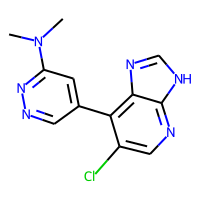
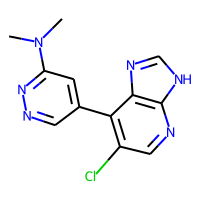
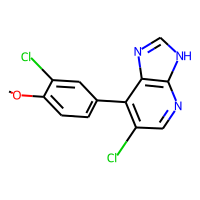
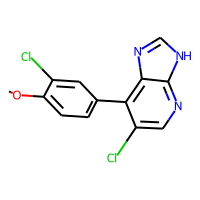
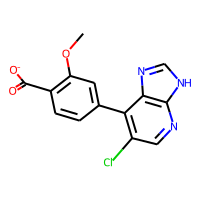

In [45]:
HTML(data[data['inchi'].duplicated(keep=False)].sort_values("inchi").head().to_html(notebook=True))

Inspecting the mean tanimoto similarity between each ligand to the respective remaining ligands.

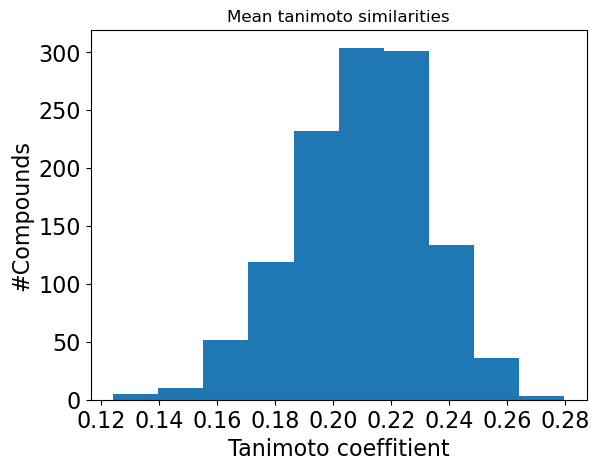

In [46]:
plt.title("Mean tanimoto similarities")
plt.hist(data['mean_tanimoto_sims'])
plt.xlabel('Tanimoto coeffitient', fontsize=16)
plt.ylabel('#Compounds', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [47]:
print(f"Tanimoto mean similarity statistics:\n{data['mean_tanimoto_sims'].describe()}")

Tanimoto mean similarity statistics:
count    1196.000000
mean        0.209746
std         0.022558
min         0.124216
25%         0.195424
50%         0.211946
75%         0.225258
max         0.279680
Name: mean_tanimoto_sims, dtype: float64


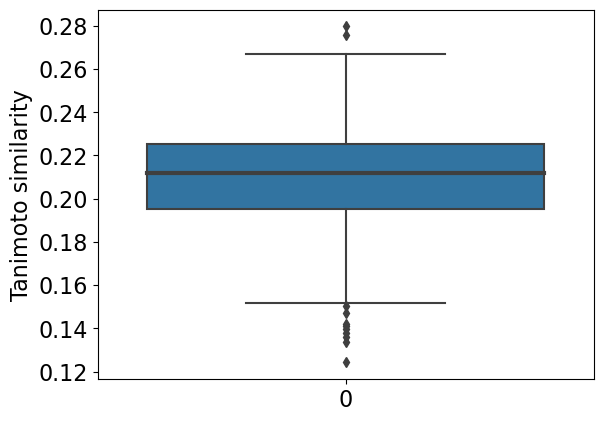

In [48]:
sns.boxplot(
    data['mean_tanimoto_sims'],
    medianprops={"linewidth": 3, "linestyle": "-"},
    )
plt.ylabel('Tanimoto similarity', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In the following, we consider that similiarities between a ligand and its respective most similiar ligand in the dataset.

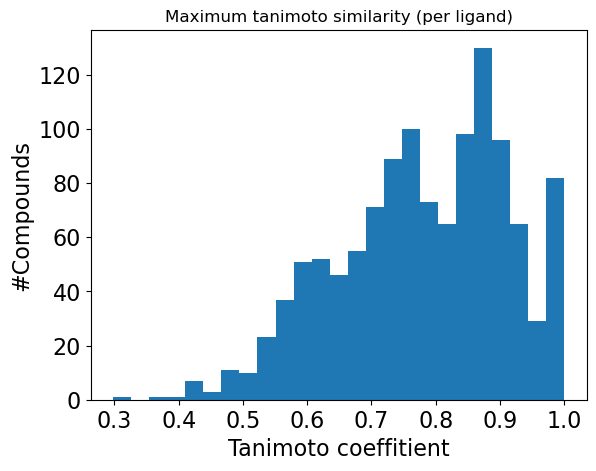

In [49]:
plt.hist(data['nearest_neighbor_sim'], bins=25)
plt.title("Maximum tanimoto similarity (per ligand)")
plt.xlabel('Tanimoto coeffitient', fontsize=16)
plt.ylabel('#Compounds', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Heatmap of Tanimoto similairties:

/home/katharina/miniforge3/envs/king_frag_lib_pocket_enum/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


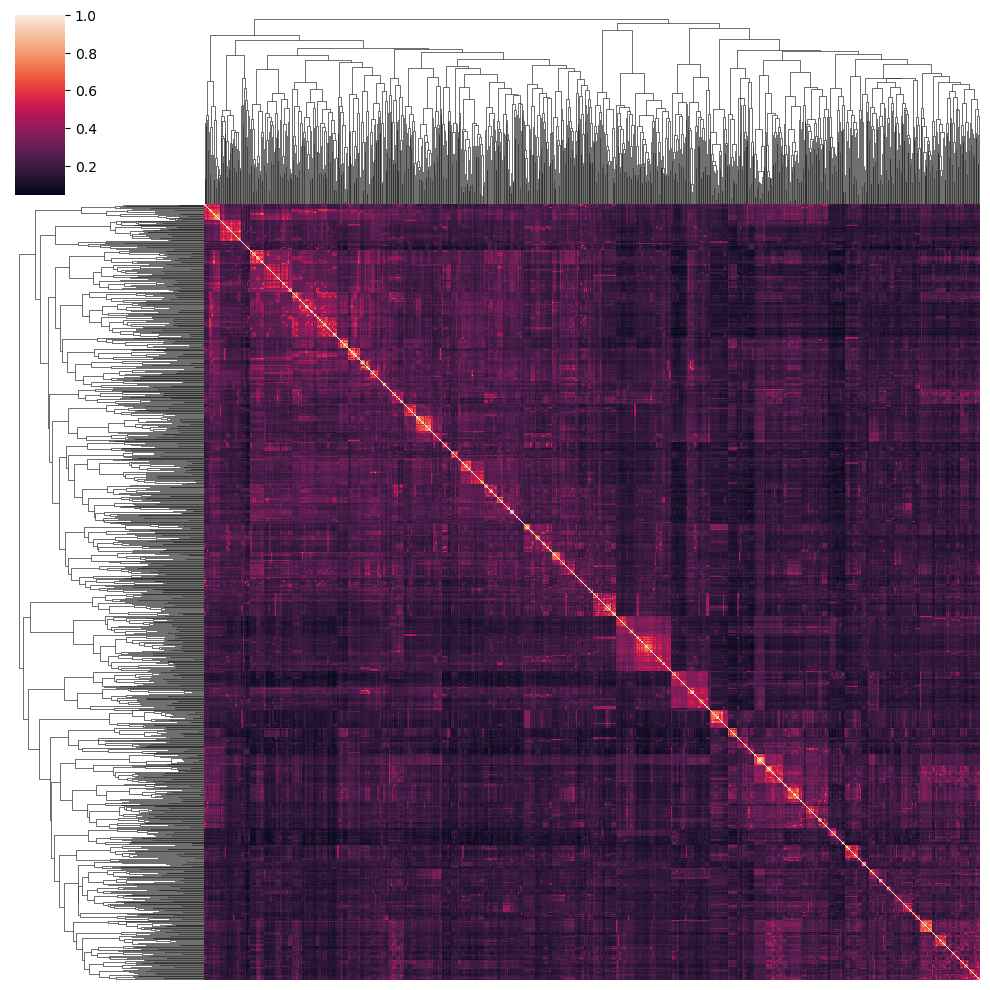

In [50]:
g = sns.clustermap(tanimoto_similarity_matrix(data['rdkit_fingerprint']), yticklabels=False, xticklabels=False)